In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import mlflow
import os
import mlflow.data

In [3]:
os.getenv('MLFLOW_TRACKING_URI')

In [4]:
mlflow.set_experiment('sistemas-de-recomendación')

<Experiment: artifact_location='file:///Users/julian/Documents/repos/sistemas-de-recomendacion/mlruns/838408446646827845', creation_time=1720131893161, experiment_id='838408446646827845', last_update_time=1720131893161, lifecycle_stage='active', name='sistemas-de-recomendación', tags={}>

In [5]:
mlflow.start_run()

<ActiveRun: >

In [6]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}


In [7]:
ratings

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [8]:
ratings.to_csv('rating.csv')

In [9]:
mlflow.log_artifact('./rating.csv')

In [10]:
dataset = mlflow.data.from_pandas(
    ratings, 
    # source=dataset_source_url,
    name="movielens",
    targets="rating"
)

In [11]:
mlflow.log_input(dataset)

/Users/julian/opt/anaconda3/envs/sistemas-de-recomendacion/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [12]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [13]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [14]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [15]:
len(ratings_train), len(ratings_val)

(80000, 20000)

In [16]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [17]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5, 1, 3.52835)

In [18]:
ratings_train['userId'].min(), ratings_train['movieId'].min()

(1, 1)

In [19]:
from keras.layers import Embedding, Input, Flatten, Dot, Add, Activation, Lambda
from keras.regularizers import l2
from keras import Model
from keras.constraints import non_neg

2024-07-04 19:39:29.246752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# Parámetros

n_latent_factors = 20
learning_rate = 0.001
epochs = 20

In [21]:
# l2_reg = l2(0.00025)
# l2_reg = l2(0.00)
movie_input = Input(shape=[1], name='Item')
movie_embedding = Embedding(n_movies + 1, 
                            n_latent_factors, 
                            # embeddings_regularizer = l2(0.001),
                            name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
# Notar que la dimensión del embedding es 1 tanto para m_biases como para u_biases
m_biases = Flatten(name='movie_biases_flt')(Embedding(
    n_movies + 1, 1, 
    name="movie_biases", 
    # embeddings_regularizer = l2_reg
)(movie_input))

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(
    n_users + 1,
    n_latent_factors,
    # embeddings_regularizer = l2_reg,
    name='User-Embedding'
)(user_input))
u_biases = Flatten(name='user_biases_flt')(Embedding(
    n_users + 1, 1, name="user_biases", 
    # embeddings_regularizer = l2_reg
)(user_input))

In [22]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
out = Add()([prod, u_biases, m_biases])
## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
#out = Activation('sigmoid')(out)
#out = Lambda(lambda x: (max_rating - min_rating) * x + min_rating)(out)
##
model = Model([user_input, movie_input], out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 20)                33660     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 20)                18880     ['User[0][0]']            

In [23]:
from keras.optimizers import Adam

In [24]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [25]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [26]:
model.compile(Adam(learning_rate=learning_rate), 'mean_squared_error', metrics=[root_mean_squared_error])

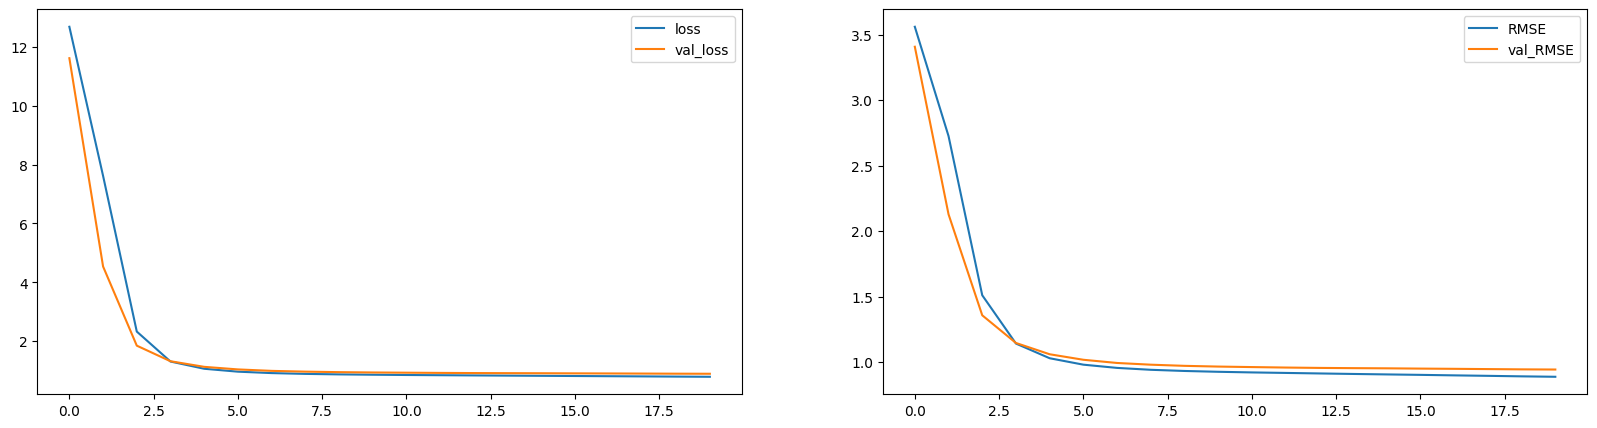

250/250 [==============================] - 1s 5ms/step - loss: 0.7919 - root_mean_squared_error: 0.8892 - val_loss: 0.8945 - val_root_mean_squared_error: 0.9445


In [27]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=320,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=epochs, 
                    callbacks = [plot_losses],
                    verbose=1)

In [28]:
loss_val, rmse_val = model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

625/625 [==============================] - 1s 2ms/step - loss: 0.8945 - root_mean_squared_error: 0.9367


In [29]:
loss_train, rmse_train = model.evaluate([ratings_train.userId, ratings_train.movieId], ratings_train.rating)

2500/2500 [==============================] - 3s 1ms/step - loss: 0.7696 - root_mean_squared_error: 0.8691


In [30]:
mlflow.log_params({
    'n_latent_factors': n_latent_factors,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'model_type': 'with_biases'
})


In [31]:
mlflow.log_metrics({
    'loss_val': loss_val, 'rmse_val':rmse_val,
    'loss_train': loss_train, 'rmse_train':rmse_train,
})

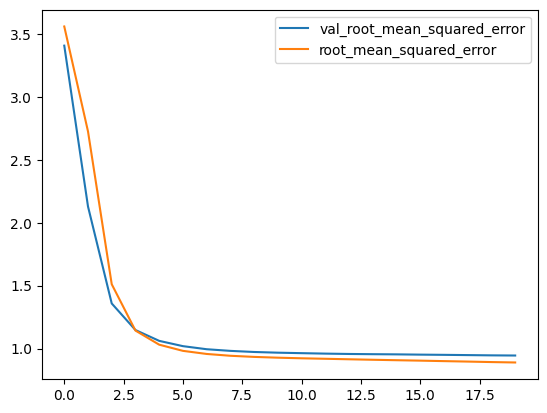

In [32]:
from matplotlib import pyplot as plt
f = plt.figure()
plt.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.legend()
mlflow.log_figure(f, 'root_mean_squared_error.png')

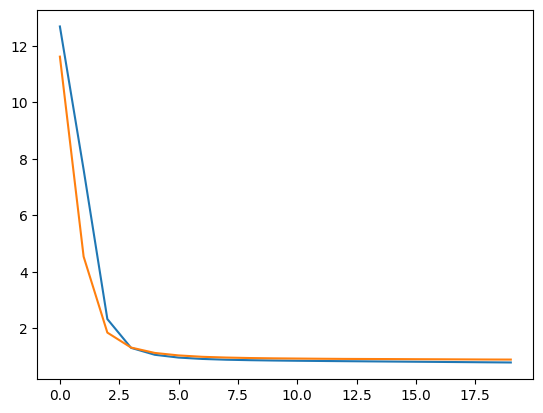

In [33]:
from matplotlib import pyplot as plt
f = plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
mlflow.log_figure(f, 'loss.png')

In [46]:
mlflow.end_run()

In [23]:
model_analisis = Model([user_input, movie_input], [prod, u_biases, m_biases])

In [24]:
products_pred, u_biases_pred, m_biases_pred = model_analisis.predict([ratings_train.userId, ratings_train.movieId])

2500/2500 [==============================] - 2s 883us/step


In [25]:
products_pred.shape

(80000, 1)

In [26]:
u_biases_pred.shape

(80000, 1)

In [27]:
m_biases_pred.shape

(80000, 1)